<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

### Imports

In [2]:
import spacy
import pandas as pd
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

### Loading/Cleaning Data

In [8]:
df = pd.read_csv('./Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [ ]:
pd.set_option('display.max_colwidth', None)

In [25]:
df['reviews.text'][14]

'we have many things that need aa battery they are great'

In [27]:
df['reviews.text'][99]

'My PS3 remote control and my television remote controls work again thanks to these AAA batteries.'

In [28]:
df['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [9]:
# subsetting by only the Electronics category

df = df[df['primaryCategories'] == 'Electronics'].copy()

In [ ]:
# Data looks ready for tokenization 🤷‍♂️

### Tokenization

In [10]:
nlp = spacy.load("en_core_web_lg")
## Using Lemmas as our tokens

tokens = []

for doc in nlp.pipe(df['reviews.text']):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop != True) and (token.pos_ != 'PRON')) and (token.is_punct !=True) and (token.is_space != True):
            doc_tokens.append(token.lemma_.strip())
            
    tokens.append(doc_tokens)

In [11]:
len(tokens) == df.shape[0]

True

In [12]:
id2word = corpora.Dictionary(tokens) #A list of list of tokens 

In [13]:
len(id2word.keys())

6831

In [14]:
id2word.filter_extremes(no_below=5, no_above=.95)

In [15]:
len(id2word.keys())

2247

In [16]:
corpora = [id2word.doc2bow(doc) for doc in tokens]

In [17]:
lda = LdaMulticore(corpus=corpora,
                  id2word=id2word,
                  num_topics=15, 
                  passes=50)

In [18]:
lda.print_topics()

[(0,
  '0.077*"app" + 0.058*"Amazon" + 0.029*"tablet" + 0.029*"store" + 0.024*"Google" + 0.023*"device" + 0.021*"web" + 0.020*"play" + 0.017*"use" + 0.015*"work"'),
 (1,
  '0.104*"price" + 0.089*"tablet" + 0.086*"good" + 0.051*"great" + 0.026*"nice" + 0.022*"quality" + 0.018*"value" + 0.014*"beat" + 0.012*"money" + 0.012*"buy"'),
 (2,
  '0.039*"good" + 0.030*"buy" + 0.027*"tablet" + 0.022*"like" + 0.020*"go" + 0.019*"product" + 0.018*"purchase" + 0.018*"time" + 0.017*"return" + 0.017*"know"'),
 (3,
  '0.082*"tablet" + 0.048*"kid" + 0.039*"great" + 0.037*"time" + 0.033*"child" + 0.029*"app" + 0.025*"free" + 0.025*"little" + 0.019*"good" + 0.017*"set"'),
 (4,
  '0.032*"card" + 0.023*"memory" + 0.023*"light" + 0.017*"good" + 0.017*"GB" + 0.016*"storage" + 0.015*"screen" + 0.014*"weight" + 0.013*"16" + 0.011*"add"'),
 (5,
  '0.046*"charge" + 0.043*"reader" + 0.030*"e" + 0.022*"buy" + 0.016*"work" + 0.015*"computer" + 0.014*"turn" + 0.014*"Kindle" + 0.014*"good" + 0.013*"problem"'),
 (6,
  

In [19]:
import re
words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]

In [20]:
topics = [' '.join(t[0:5]) for t in words]

In [21]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
app Amazon tablet store Google

------ Topic 1 ------
price tablet good great nice

------ Topic 2 ------
good buy tablet like go

------ Topic 3 ------
tablet kid great time child

------ Topic 4 ------
card memory light good GB

------ Topic 5 ------
charge reader e buy work

------ Topic 6 ------
Kindle read book Fire love

------ Topic 7 ------
great recommend product purchase tablet

------ Topic 8 ------
great size sound screen picture

------ Topic 9 ------
fire kindle tablet 8 well

------ Topic 10 ------
love buy old year tablet

------ Topic 11 ------
tablet battery great life use

------ Topic 12 ------
easy use tablet love great

------ Topic 13 ------
case kid app tablet long

------ Topic 14 ------
game play watch movie book



In [22]:
# Part 1: Topic Distance Visualization
"""
Tells us if the topics are distinct, and what terms are most import important to the topic distribution.
"""

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [23]:
pyLDAvis.gensim.prepare(lda,corpora,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.255255 -0.143600       1        1  10.863438
6     -0.052495 -0.117731       2        1   8.276204
1      0.077118 -0.047085       3        1   8.167667
8      0.034693 -0.019346       4        1   7.026353
3      0.013979  0.150383       5        1   6.952649
0      0.140123  0.208545       6        1   6.803502
12    -0.213413  0.101822       7        1   6.562288
13     0.060610  0.103380       8        1   6.330433
14    -0.201261  0.162827       9        1   6.157315
2      0.110769 -0.097922      10        1   6.085947
11     0.029252  0.098266      11        1   5.717672
9      0.073568 -0.141564      12        1   5.600201
4      0.178882 -0.075519      13        1   5.392687
5      0.120301 -0.046592      14        1   5.102989
7     -0.116872 -0.135865      15        1   4.960655, topic_info=        Term         Freq        Total Category  logprob  loglift
68      easy  2523.000000  2523.000000  Default  30.0000  30.0000
202      use  3420.000000  3420.000000  Default  29.0000  29.0000
5       love  4478.000000  4478.000000  Default  28.0000  28.0000
806     game  1452.000000  1452.000000  Default  27.0000  27.0000
90     price  1997.000000  1997.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
23      look    72.321777   637.031799  Topic15  -4.8443   0.8279
308  awesome    57.517677   340.230133  Topic15  -5.0733   1.2261
615    money    57.580795   341.689087  Topic15  -5.0722   1.2229
659      far    60.871536   497.748596  Topic15  -5.0166   0.9023
192    enjoy    57.385952   648.073303  Topic15  -5.0756   0.5794

[1041 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
951       3  0.178292       $
951       6  0.002547       $
951      10  0.160462       $
951      12  0.491575       $
951      13  0.165556       $
...     ...       ...     ...
935       9  0.115988   young
935      15  0.103779   young
1032      1  0.994536      yr
432       4  0.929529  zipper
2094      7  0.922329       ©

[2399 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 2, 9, 4, 1, 13, 14, 15, 3, 12, 10, 5, 6, 8])

In [24]:
distro = [lda[d] for d in corpora]

In [25]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [26]:
doc_topics = pd.DataFrame.from_records(new_distro)
doc_topics.columns = topics
doc_topics.head()

,app Amazon tablet store Google,price tablet good great nice,good buy tablet like go,tablet kid great time child,card memory light good GB,charge reader e buy work,Kindle read book Fire love,great recommend product purchase tablet,great size sound screen picture,fire kindle tablet 8 well,love buy old year tablet,tablet battery great life use,easy use tablet love great,case kid app tablet long,game play watch movie book
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406834,0.000000,0.000000,0.000000,0.334750,0.000000,0.000000,0.158410,0.000000
1,0.015365,0.000000,0.168896,0.148642,0.000000,0.273965,0.039790,0.000000,0.131763,0.000000,0.000000,0.000000,0.000000,0.210908,0.000000
2,0.267177,0.022224,0.022224,0.022224,0.022224,0.022224,0.022224,0.022224,0.022224,0.443917,0.022224,0.022224,0.022224,0.022224,0.022224
3,0.000000,0.140945,0.000000,0.061727,0.332038,0.133471,0.000000,0.000000,0.060796,0.018220,0.041156,0.000000,0.012141,0.184570,0.011816
4,0.000000,0.000000,0.000000,0.154314,0.169455,0.000000,0.237823,0.000000,0.203037,0.000000,0.000000,0.000000,0.000000,0.179802,0.000000


In [27]:
doc_topics['primary_topic'] = doc_topics.idxmax(axis=1)
doc_topics['primary_topic'].value_counts()

love buy old year tablet                   2354
price tablet good great nice               1441
Kindle read book Fire love                 1168
easy use tablet love great                 1135
great size sound screen picture            1065
tablet kid great time child                 921
great recommend product purchase tablet     885
game play watch movie book                  860
tablet battery great life use               681
good buy tablet like go                     676
fire kindle tablet 8 well                   661
case kid app tablet long                    617
app Amazon tablet store Google              580
charge reader e buy work                    522
card memory light good GB                   429
Name: primary_topic, dtype: int64

In [28]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    coherence_values = []   
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
    return coherence_values

In [29]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpora,
                                                        start=3, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=1)

In [30]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [31]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,3,-2.163287
1,0,5,-2.172396
2,0,7,-2.152587
3,0,9,-2.211954
4,0,11,-2.214549


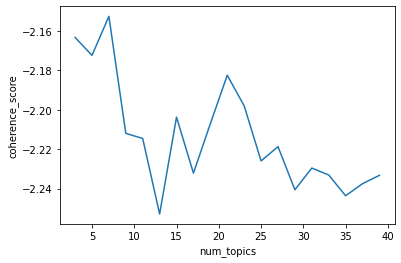

In [32]:
import seaborn as sns
 
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling